In [1]:
import sys
sys.path.insert(0, '../')

In [2]:
from pydicom import dcmread
import numpy as np
import matplotlib.pyplot as plt
import os
from python_scripts import important_functions, twix_recon, robustcc, DICOM_recon_bssfp, bssfp, adaptive_combine
import mapvbvd
from scipy.io import savemat, loadmat
from skimage.measure import EllipseModel
from matplotlib.patches import Ellipse
import math
from tqdm import tqdm

C:\Users\krith\Anaconda3\envs\tf2\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Load in the simulated 12 phase-cycled bSSFP phantom coil data

In [4]:
filepath = r'C:\Users\krith\OneDrive - Imperial College London\PhD\Year_1\MP2\simulated_phantom_data'
os.chdir(filepath)

bssfp_coil_data = np.load("simulated_phantom_12pcbssfp_coil_images.npy")

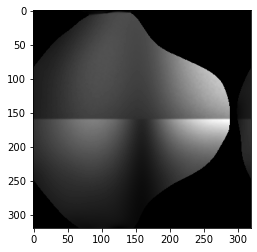

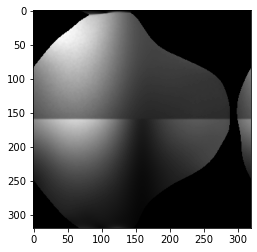

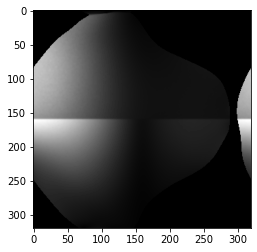

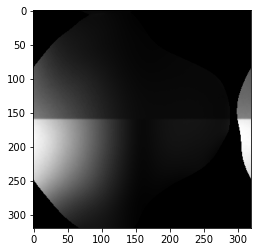

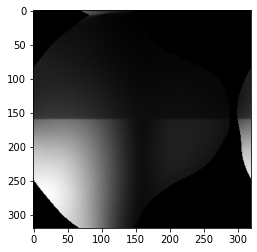

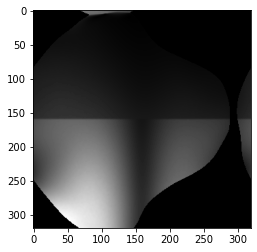

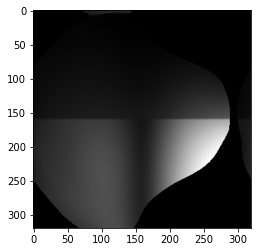

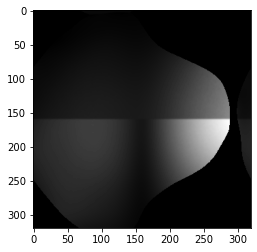

In [4]:
for i in range(bssfp_coil_data.shape[2]):
    plt.figure()
    plt.imshow(np.abs(bssfp_coil_data[:,:,i,0]), cmap = 'gray')

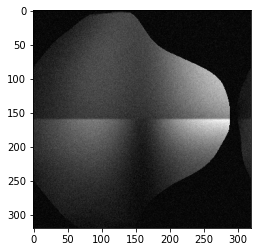

In [5]:
noisy_bssfp_coil_data = bssfp.add_noise_gaussian(bssfp_coil_data,mu=0,sigma=0.002)

plt.figure()
plt.imshow(np.abs(noisy_bssfp_coil_data[:,:,0,0]), cmap = 'gray')

## ESPIRIT

line 75


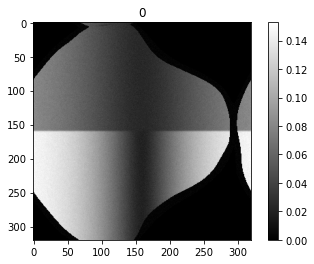

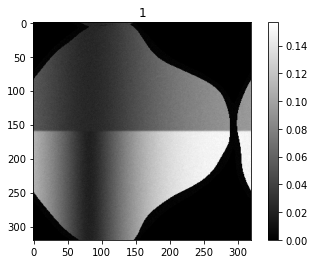

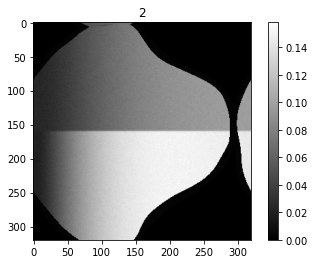

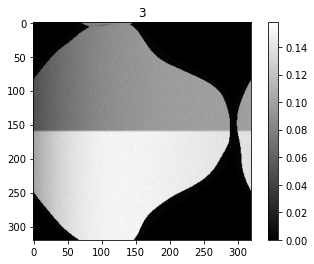

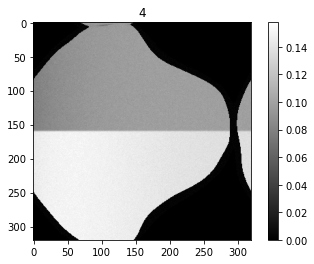

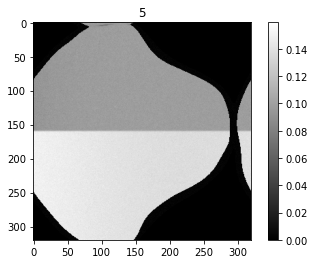

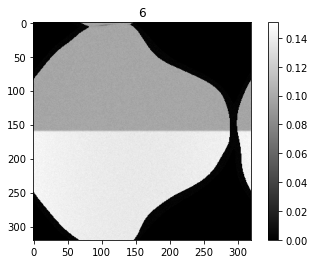

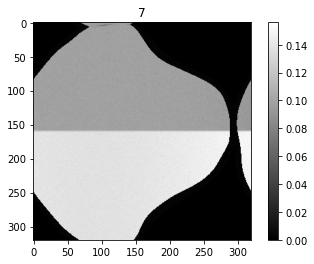

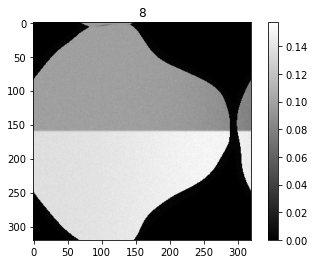

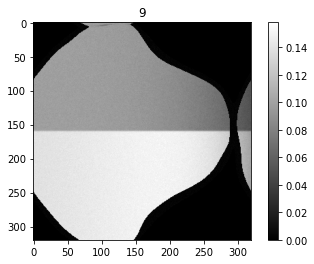

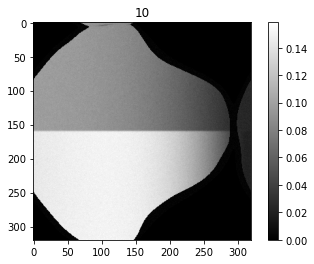

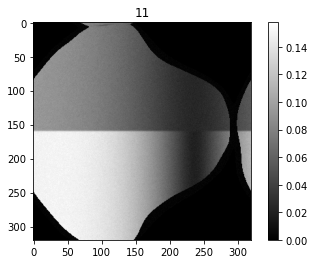

In [6]:
esp, knee_espirit = twix_recon.do_espirit_recon_bssfp(noisy_bssfp_coil_data)

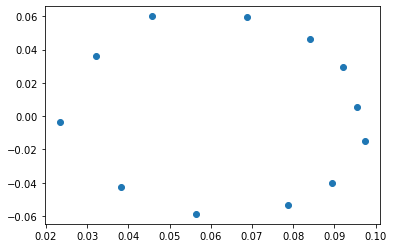

In [7]:
plt.figure()
plt.scatter(knee_espirit[150,150,:].real, knee_espirit[150,150,:].imag)

## Simple phase RCC

In [8]:
knee_rcc_simple = robustcc.robustcc(noisy_bssfp_coil_data, coil_axis = -2, pc_axis = -1)

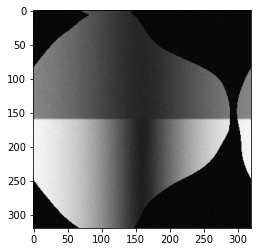

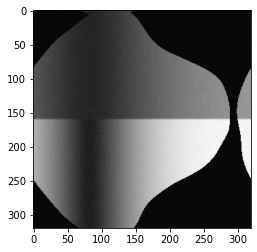

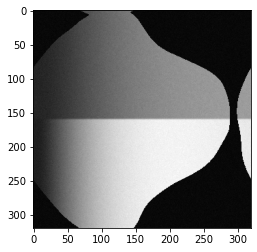

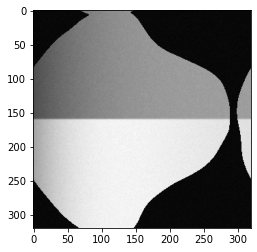

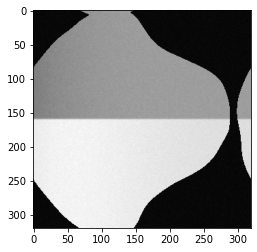

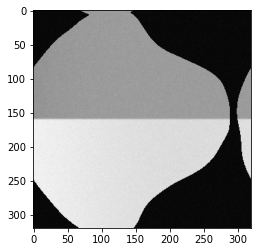

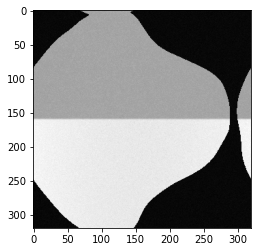

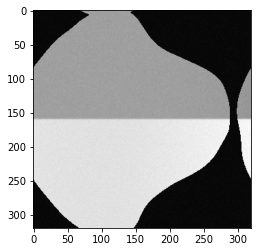

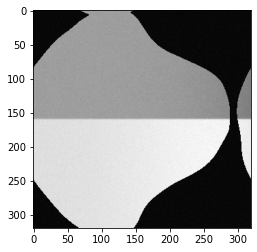

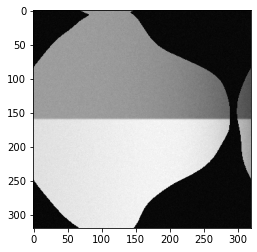

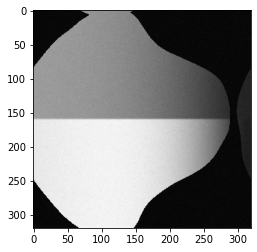

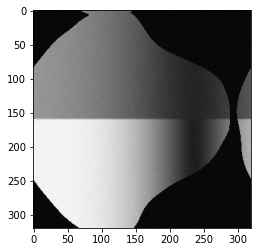

In [9]:
for i in range(knee_rcc_simple.shape[1]):
    plt.figure()
    plt.imshow(np.abs(knee_rcc_simple[:,i,:]), cmap = 'gray')

(320, 320, 12)


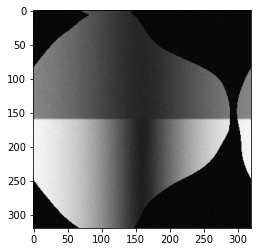

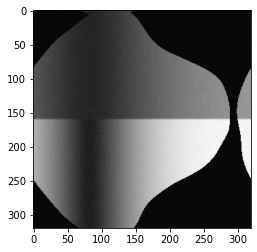

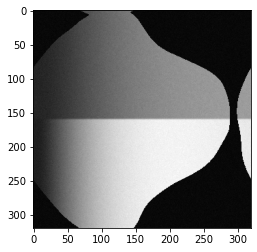

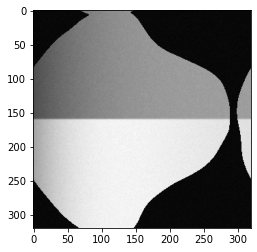

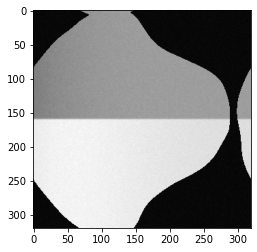

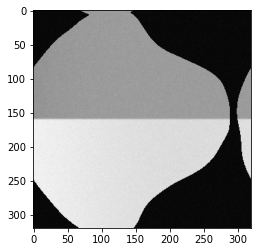

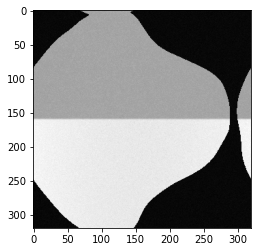

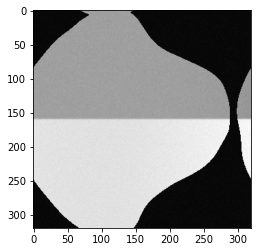

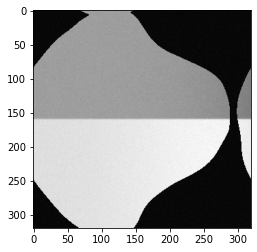

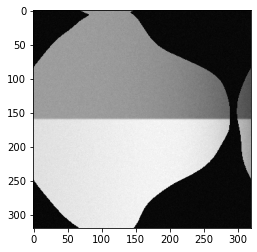

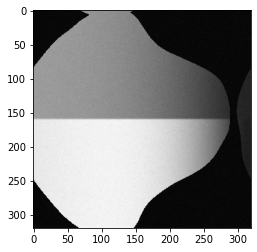

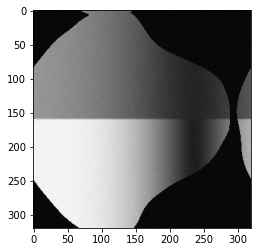

In [10]:
knee_rcc_simple_axorg = np.moveaxis(knee_rcc_simple, [0,1,2], [0,2,1])

print(knee_rcc_simple_axorg.shape)

for i in range(knee_rcc_simple_axorg.shape[2]):
    plt.figure()
    plt.imshow(np.abs(knee_rcc_simple_axorg[:,:,i]), cmap = 'gray')

In [11]:
knee_rcc_simple_axorg.shape

(320, 320, 12)

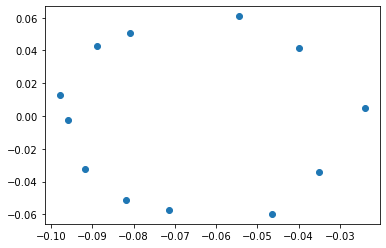

In [12]:
plt.figure()
plt.scatter(knee_rcc_simple_axorg[150,150,:].real, knee_rcc_simple_axorg[150,150,:].imag)

## Full phase RCC

In [13]:
knee_rcc_full = robustcc.robustcc(noisy_bssfp_coil_data, method = 'full', coil_axis = -2, pc_axis = -1) #possible that this error 
#will go away when I add some noise

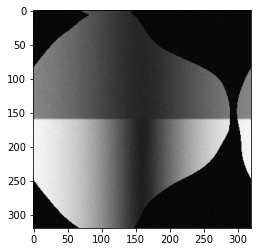

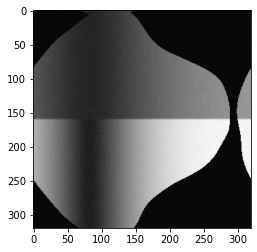

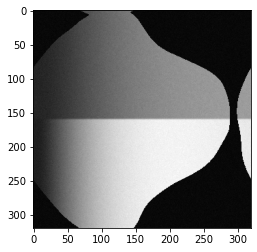

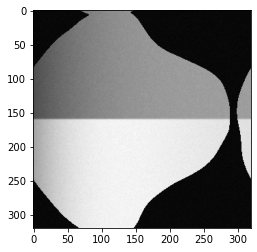

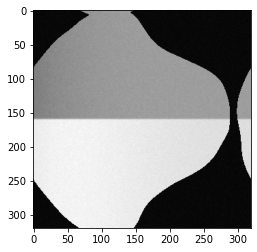

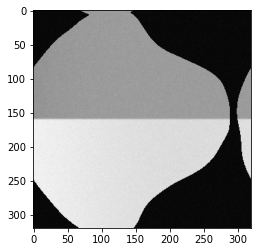

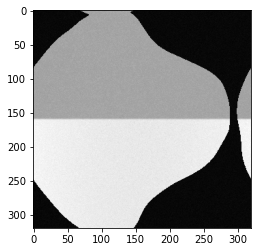

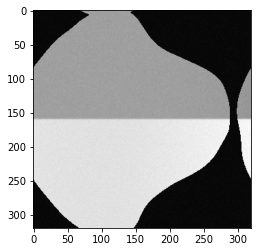

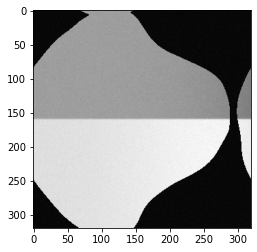

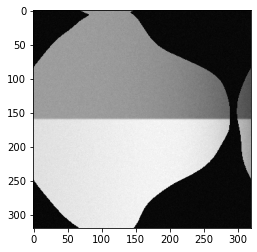

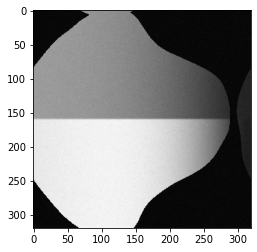

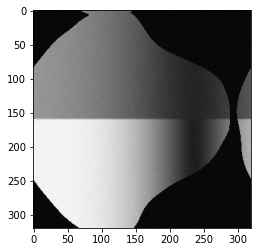

In [14]:
for i in range(knee_rcc_full.shape[1]):
    plt.figure()
    plt.imshow(np.abs(knee_rcc_full[:,i,:]), cmap = 'gray')

(320, 320, 12)


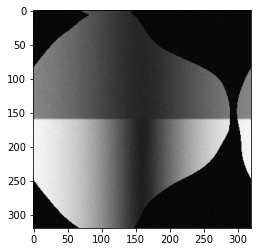

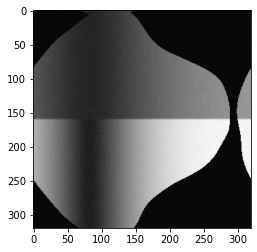

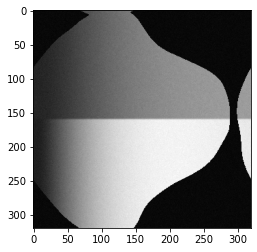

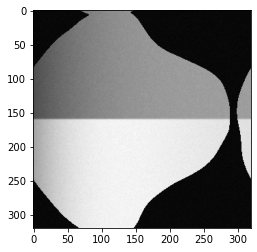

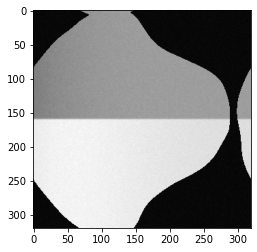

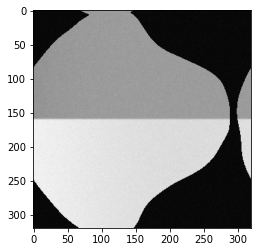

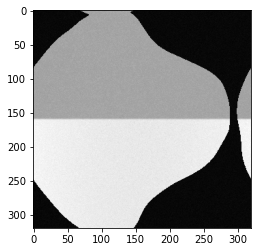

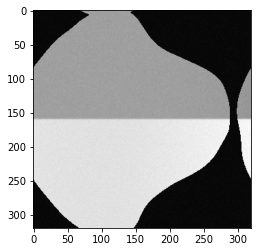

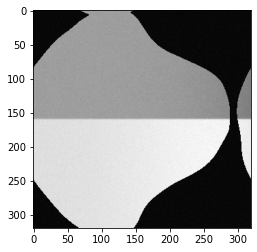

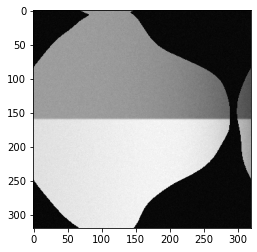

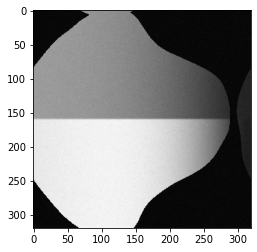

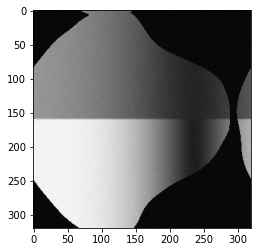

In [15]:
knee_rcc_full_axorg = np.moveaxis(knee_rcc_full, [0,1,2], [0,2,1])

print(knee_rcc_full_axorg.shape)

for i in range(knee_rcc_full_axorg.shape[2]):
    plt.figure()
    plt.imshow(np.abs(knee_rcc_full_axorg[:,:,i]), cmap = 'gray')

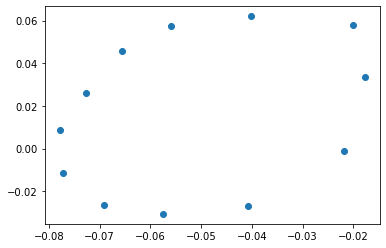

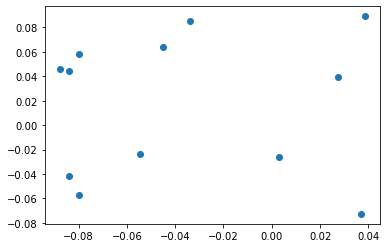

In [16]:
plt.figure()
plt.scatter(noisy_bssfp_coil_data[100,250,0,:].real, noisy_bssfp_coil_data[100,250,0,:].imag)

plt.figure()
plt.scatter(knee_rcc_full_axorg[100,250,:].real, knee_rcc_full_axorg[100,250,:].imag)

## Adaptive Combine

In [17]:
AC_data = adaptive_combine.bssfp_adaptive_combine(noisy_bssfp_coil_data)

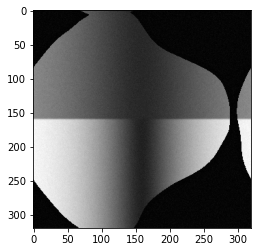

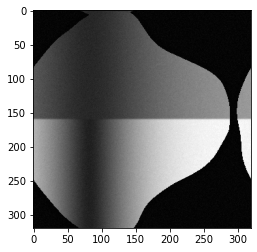

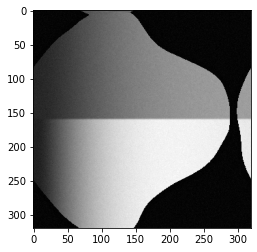

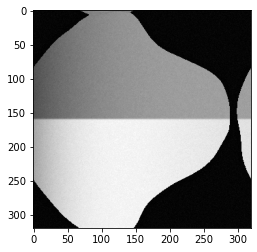

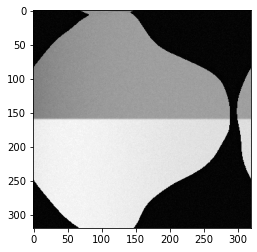

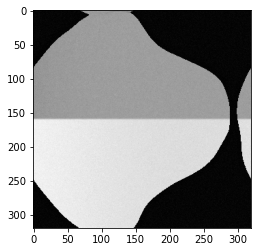

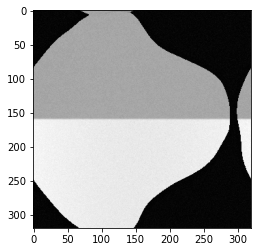

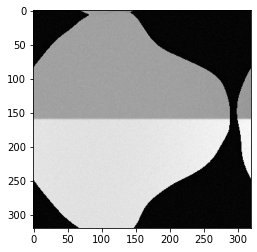

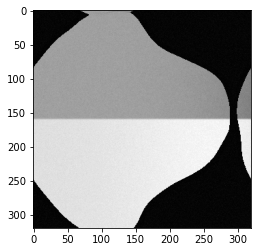

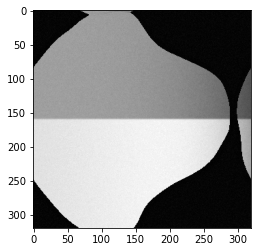

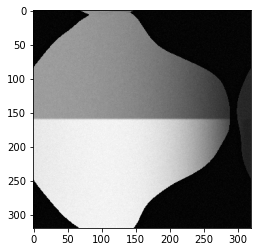

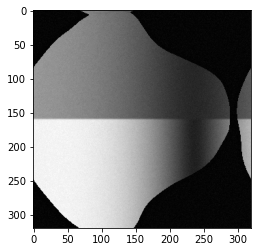

In [18]:
for i in range(12):
    plt.figure()
    plt.imshow(np.abs(AC_data[:,:,i]), cmap = 'gray')

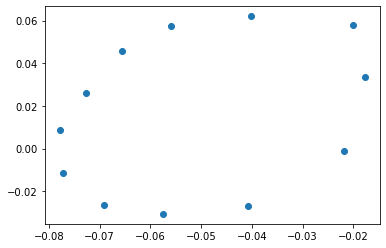

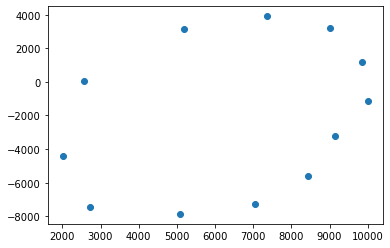

In [19]:
plt.figure()
plt.scatter(noisy_bssfp_coil_data[100,250,0,:].real, noisy_bssfp_coil_data[100,250,0,:].imag)

plt.figure()
plt.scatter(AC_data[100,250,:].real, AC_data[100,250,:].imag)

## Identifying relevant SNRs and standard deviation values

In [6]:
noisy_bssfp_coil_data.shape

(320, 320, 8, 12)

In [6]:
%matplotlib

plt.figure()
plt.imshow(np.abs(noisy_bssfp_coil_data[:,:,0,0]), cmap = 'gray')

Using matplotlib backend: Qt5Agg


ROIs to use:
1. tissue-like area: [90:140, 200:240] --> ie. the top section
2. noise           : [10:50 , 220:300]

In [31]:
def rayleigh_to_gaussian_std(rayleigh_std):
    """
    Convert Rayleigh standard deviation to Gaussian standard deviation.

    Parameters:
    - rayleigh_std (float): Standard deviation of the Rayleigh distribution.

    Returns:
    - gaussian_std (float): Standard deviation of the equivalent Gaussian distribution.
    """
    gaussian_std = rayleigh_std / np.sqrt(2)
    return gaussian_std

In [20]:
noisy_bssfp_coil_data

array([[[[ 1.35411773e-03-2.03543685e-03j,
           3.56589574e-03+1.24988796e-03j,
          -1.78165619e-03-3.83576050e-04j, ...,
           7.78665205e-04+2.68121630e-03j,
          -3.74664979e-03+2.23576674e-04j,
          -4.88350761e-03-7.02460533e-04j],
         [-1.22759928e-04-6.05544110e-03j,
           1.71320728e-03+2.71086484e-03j,
           1.60613342e-04+3.39885281e-03j, ...,
           2.34784097e-03+6.44880352e-05j,
           2.31840663e-03+2.49448827e-03j,
           3.63430609e-03-1.31473580e-03j],
         [ 1.55640647e-03+4.67400871e-03j,
          -2.57274627e-03-2.41128573e-04j,
          -1.51890561e-03-2.72183299e-03j, ...,
          -3.06131707e-03+4.01784235e-03j,
           1.25873454e-03-3.43741111e-04j,
          -1.67329737e-03+3.45364970e-03j],
         ...,
         [-2.86333029e-03+8.16744345e-04j,
           1.85449128e-03+3.17126153e-03j,
           1.25487520e-03+7.64351224e-04j, ...,
           1.76863365e-03+1.43455149e-03j,
           2.2088

In [11]:
bssfp_coil_data.shape

(320, 320, 8, 12)

0.0005996259873594904
The average SNR across all the phase cycles for a cartilage ROI is: 101.68925810094989


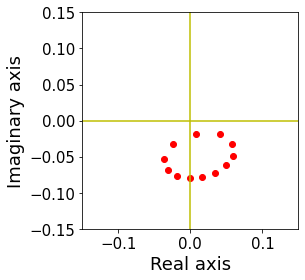

In [42]:
# Calculate the SNR of the single coil phase-cycled bSSFP signals - to keep it consistent with the in-vivo SNR sensitivity
# analysis

noisy_bssfp_coil_data = bssfp.add_noise_gaussian(bssfp_coil_data,mu=0,sigma=0.0006)

#Step 1: get the rayleigh noise standard deviation from the noise scan magnitude image 
std_dev_rayleigh = np.std(np.abs(noisy_bssfp_coil_data[10:50, 220:300, 0, :]))

#Step 2: convert rayleigh std dev to gaussian std dev
std_dev_gaussian = important_functions.convert_rayleighStdDev_to_gaussianStdDev(std_dev_rayleigh)

print(std_dev_gaussian)

#Step 3: ROI-average the full cartilage region
averaged_signal = np.average(noisy_bssfp_coil_data[90:140, 200:240, 0, :], axis = (0,1))
#print(averaged_signal.shape)

#Step 4: Calculate magnitude per phase cycle
magnitude_per_phase_cycle = np.abs(averaged_signal) #Finding the average cartilage magnitude per phase cycle
#print(magnitude_per_phase_cycle) #As can be seen, there is a wide range of signals

#Step 5: Calculate SNR per phase cycle
SNR_per_phase_cycle = magnitude_per_phase_cycle/std_dev_gaussian
#print(SNR_per_phase_cycle)

#Step 6: Calculate overall SNR
average_SNR = np.average(SNR_per_phase_cycle)
print("The average SNR across all the phase cycles for a cartilage ROI is: " + str(average_SNR))


#Plotting the ellipses
fig, axs = plt.subplots()
axs.scatter(noisy_bssfp_coil_data[100,230,0,:].imag, noisy_bssfp_coil_data[100,230,0,:].real, c = 'r')
axs.set_xlim([-0.15, 0.15])
axs.set_ylim([-0.15, 0.15])
axs.tick_params(axis='both', which='major', labelsize=15)
axs.set_xlabel("Real axis", fontsize = 18)
axs.set_ylabel("Imaginary axis", fontsize = 18)
axs.axvline(0, c = 'y')
axs.axhline(0, c = 'y')
axs.set_aspect(1)
fig.tight_layout()

10 SNR and standard deviation values - varying in multiples of six. Note the standard deviations mentioned here are the values
I input into the 'add_gaussian_noise' function to simulate uncorrelated gaussian noise for the real and imaginary channels.
This is NOT the end gaussian noise that is computed from the image (refer B.4.1 in the Haacke book (Appendix B).

- SNR: 10, std dev: 0.006
- SNR: 20, std dev: 0.003
- SNR: 30, std dev: 0.002
- SNR: 40, std dev: 0.0015
- SNR: 50, std dev: 0.0012


- SNR: 60, std dev: 0.001
- SNR: 70, std dev: 0.00087
- SNR: 80, std dev: 0.00075
- SNR: 90, std dev: 0.00067
- SNR: 100, std dev: 0.0006


(50, 40, 12)
(50,)
(40,)


 ...]

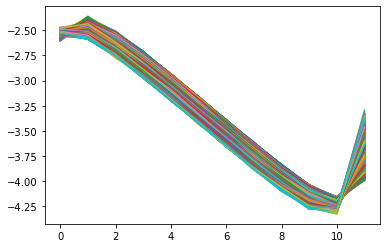

In [68]:
phase_0th_coil = []
angle_0th_coil = np.angle(noisy_bssfp_coil_data[90:140, 200:240,0,:])
print(angle_0th_coil.shape)
rows = np.arange(90, 140, 1)
cols = np.arange(200,240,1)


print(rows.shape)
print(cols.shape)

for r in range(len(rows)):
    for c in range(len(cols)):
        phase_0th_coil.append(important_functions.phaseUnwrapping(angle_0th_coil[r, c, :]))
        
plt.figure()
plt.plot(range(12), np.transpose(phase_0th_coil))

In [71]:
np.array(phase_0th_coil).shape


(2000, 12)

In [129]:
def RMSE_simulated_phantom(noisy_phantom, coil_combined_data):
    """
    This function calculates the RMSE between the phase of the 0th coil data and the phase of the coil-combined data 
    within the region [90:140, 200:240].

    Arguments:
    noisy_phantom: (nr, nc, coil, pc)  - complex array
    coil_combined_data: (nr, nc, pc) - complex array

    Returns:
    RMSE: float
    """
    rows = np.arange(90, 140, 1)
    cols = np.arange(200,240,1)

    #Get the phase of the 0th coil data and do phase unwrapping on the phase data
    phase_0th_coil = []
    angle_0th_coil = np.angle(noisy_phantom[90:140, 200:240,0,:])

    for r in range(len(rows)):
        for c in range(len(cols)):
            phase_0th_coil.append(important_functions.phaseUnwrapping(angle_0th_coil[r, c, :]))

    phase_0th_coil = np.array(phase_0th_coil)

    #Get the phase of the coil combined data and do phase unwrapping on the phase data
    phase_coil_combined = []
    angle_coil_combined = np.angle(coil_combined_data[90:140, 200:240,:])
    counter = 0
    for r in range(len(rows)):
        for c in range(len(cols)):
            phase_coil_combined.append(important_functions.phaseUnwrapping(angle_coil_combined[r, c, :]))
            #print(counter)
            #print(important_functions.phaseUnwrapping(angle_coil_combined[r, c, :]))
            counter+=1

    phase_coil_combined = np.array(phase_coil_combined)
     
    #Calculate the RMSE
    phase_0th_coil_zeroline = np.transpose(np.subtract(np.transpose(phase_0th_coil), phase_0th_coil[:,0]))
    print(phase_0th_coil_zeroline.shape)
    phase_coil_combined_zeroline = np.transpose(np.subtract(np.transpose(phase_coil_combined), phase_coil_combined[:,0]))
    print(phase_coil_combined_zeroline.shape)
    RMSE = np.sqrt(np.mean((phase_0th_coil_zeroline - phase_coil_combined_zeroline)**2))
        
    plt.figure()
    plt.plot(range(12), np.transpose(phase_0th_coil)-phase_0th_coil[:,0])
    plt.ylabel("Phase (radians)")
    plt.xlabel("Phase cycle number")
    plt.title("Single coil phase")
    
    plt.figure()
    plt.plot(range(12), np.transpose(phase_coil_combined)-phase_coil_combined[:,0])
    plt.ylabel("Phase (radians)")
    plt.xlabel("Phase cycle number")
    plt.title("Coil combined phase")

    return RMSE

(2000, 12)
(2000, 12)
3.2127123548615537


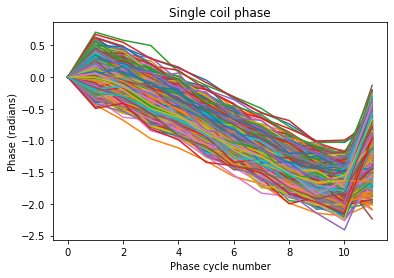

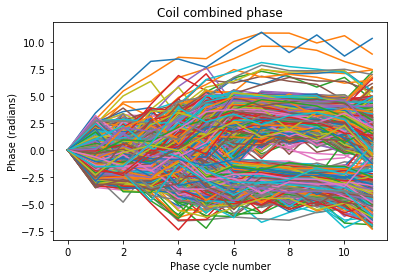

In [130]:
RMSE = RMSE_simulated_phantom(noisy_bssfp_coil_data, knee_rcc_full_axorg)
print(RMSE) #Note: this is in radians... -pi to pi

In [128]:
x = np.array([[0,1,2,3,4,5], [6,7,8,9,10,11]])
print(x.shape)
print(x)

test = np.transpose(np.subtract(np.transpose(x),x[:,0]))
print(test)

(2, 6)
[[ 0  1  2  3  4  5]
 [ 6  7  8  9 10 11]]
[[0 1 2 3 4 5]
 [0 1 2 3 4 5]]


## Testing phase preservation for espirit, srcc and frcc

In [7]:
#Load the relevant data

filepath = r'C:\Users\krith\OneDrive - Imperial College London\PhD\Year_1\MP2\simulated_phantom_data'
os.chdir(filepath)

espirit_rmse_SNR_data = np.empty((10,100), dtype = 'float64')
srcc_rmse_SNR_data = np.empty((10,100), dtype = 'float64')
frcc_rmse_SNR_data = np.empty((10,100), dtype = 'float64')
ac_rmse_SNR_data = np.empty((10,100), dtype = 'float64')
impa_rmse_SNR_data = np.empty((10,100), dtype = 'float64')

# List of different SNR values
SNR = [6,12,18,24,30,36,42,48,54,60]

for s in range(len(SNR)):
    
    espirit_rmse_SNR_data[s, :] = np.load('RMSE_espirit_SNR_' + str(SNR[s]) + '.npy')
    srcc_rmse_SNR_data[s, :] = np.load('RMSE_srcc_SNR_' + str(SNR[s]) + '.npy')
    frcc_rmse_SNR_data[s, :] = np.load('RMSE_frcc_SNR_' + str(SNR[s]) + '.npy')
    ac_rmse_SNR_data[s, :] = np.load('RMSE_adaptive_combine_SNR_' + str(SNR[s]) + '.npy')
    impa_rmse_SNR_data[s, :] = np.load('RMSE_impa_SNR_' + str(SNR[s]) + '.npy')
    
avg_espirit_SNR = np.average(espirit_rmse_SNR_data, axis = 1)
avg_srcc_SNR = np.average(srcc_rmse_SNR_data, axis = 1)
avg_frcc_SNR = np.average(frcc_rmse_SNR_data, axis = 1)
avg_ac_SNR = np.average(ac_rmse_SNR_data, axis = 1)
avg_impa_SNR = np.average(impa_rmse_SNR_data, axis = 1)

(100,)
(100,)
(100,)
(100,)
(100,)
(100,)
(100,)
(100,)
(100,)
(100,)


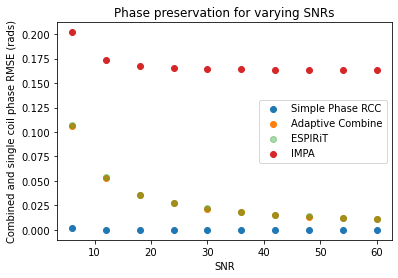

In [4]:
plt.figure()
plt.scatter(SNR, avg_srcc_SNR, label = 'Simple Phase RCC')
plt.scatter(SNR, avg_ac_SNR, label = 'Adaptive Combine')
plt.scatter(SNR, avg_espirit_SNR, label = 'ESPIRiT', alpha=0.4)
#plt.scatter(SNR, avg_frcc_SNR, label = 'Full Phase RCC')
plt.scatter(SNR, avg_impa_SNR, label = 'IMPA')
plt.title('Phase preservation for varying SNRs')
plt.xlabel("SNR")
plt.ylabel("Combined and single coil phase RMSE (rads)")
plt.legend()

(10,)


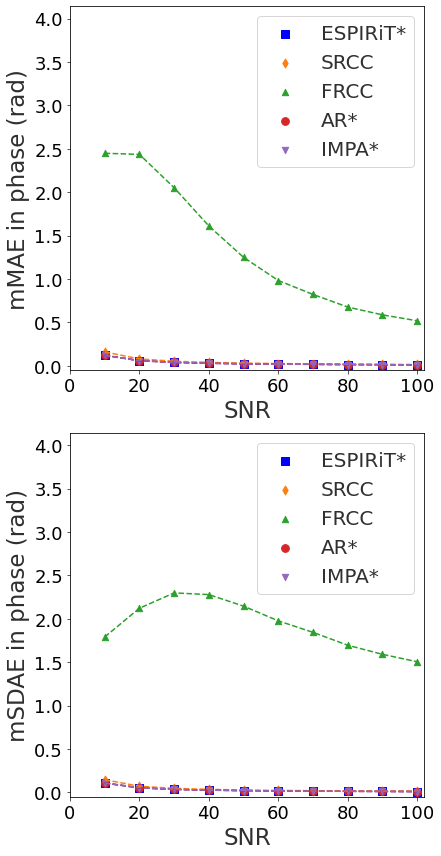

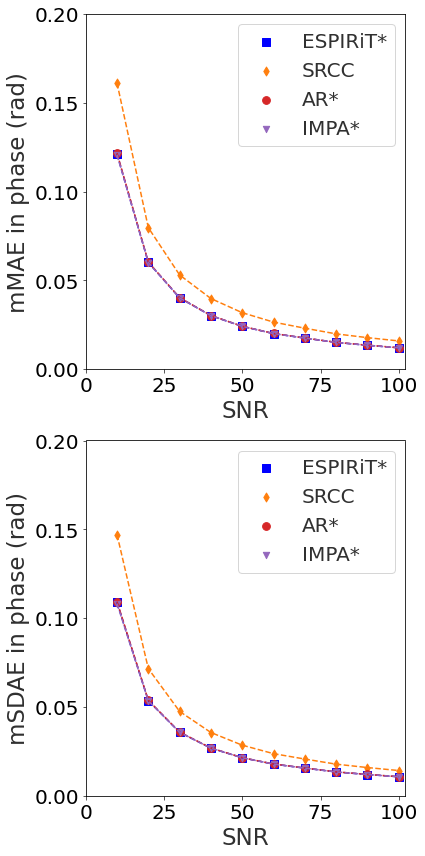

In [3]:
from scipy.optimize import curve_fit
import matplotlib.ticker as ticker

def exponential_func(x, a, b):
    return a * np.exp(b * x)

filepath = r'D:\MP2\simulated_phantom_data'
os.chdir(filepath)
SNR = np.arange(10,101,10)

espirit_bias_SNR_data = np.empty((10,100), dtype = 'float64')
srcc_bias_SNR_data = np.empty((10,100), dtype = 'float64')
frcc_bias_SNR_data = np.empty((10,100), dtype = 'float64')
ac_bias_SNR_data = np.empty((10,100), dtype = 'float64')
impa_bias_SNR_data = np.empty((10,100), dtype = 'float64')

espirit_variance_SNR_data = np.empty((10,100), dtype = 'float64')
srcc_variance_SNR_data = np.empty((10,100), dtype = 'float64')
frcc_variance_SNR_data = np.empty((10,100), dtype = 'float64')
ac_variance_SNR_data = np.empty((10,100), dtype = 'float64')
impa_variance_SNR_data = np.empty((10,100), dtype = 'float64')

for s in range(len(SNR)):
    
    espirit_bias_SNR_data[s, :] = np.load('bias1_espirit_SNR_' + str(SNR[s]) + '.npy')
    srcc_bias_SNR_data[s, :] = np.load('bias1_srcc_SNR_' + str(SNR[s]) + '.npy')
    frcc_bias_SNR_data[s, :] = np.load('bias1_frcc_SNR_' + str(SNR[s]) + '.npy')
    ac_bias_SNR_data[s, :] = np.load('bias1_adaptive_combine_SNR_' + str(SNR[s]) + '.npy')
    impa_bias_SNR_data[s, :] = np.load('bias1_impa_SNR_' + str(SNR[s]) + '.npy')
    
    espirit_variance_SNR_data[s, :] = np.load('variance1_espirit_SNR_' + str(SNR[s]) + '.npy')
    srcc_variance_SNR_data[s, :] = np.load('variance1_srcc_SNR_' + str(SNR[s]) + '.npy')
    frcc_variance_SNR_data[s, :] = np.load('variance1_frcc_SNR_' + str(SNR[s]) + '.npy')
    ac_variance_SNR_data[s, :] = np.load('variance1_adaptive_combine_SNR_' + str(SNR[s]) + '.npy')
    impa_variance_SNR_data[s, :] = np.load('variance1_impa_SNR_' + str(SNR[s]) + '.npy')
    
avg_bias_espirit_SNR = np.average(espirit_bias_SNR_data, axis = 1)
avg_bias_srcc_SNR = np.average(srcc_bias_SNR_data, axis = 1)
avg_bias_frcc_SNR = np.average(frcc_bias_SNR_data, axis = 1)
avg_bias_ac_SNR = np.average(ac_bias_SNR_data, axis = 1)
avg_bias_impa_SNR = np.average(impa_bias_SNR_data, axis = 1)

avg_variance_espirit_SNR = np.average(espirit_variance_SNR_data, axis = 1)
avg_variance_srcc_SNR = np.average(srcc_variance_SNR_data, axis = 1)
avg_variance_frcc_SNR = np.average(frcc_variance_SNR_data, axis = 1)
avg_variance_ac_SNR = np.average(ac_variance_SNR_data, axis = 1)
avg_variance_impa_SNR = np.average(impa_variance_SNR_data, axis = 1)

print(avg_bias_impa_SNR.shape)

fig, axs = plt.subplots(2, 1, figsize=(6, 12))
marker_types = ['s', 'd', '^', 'o', 'v']
marker_sizes = [60 if label in ['ESPIRiT', 'AR'] else 40 for label in ['ESPIRiT', 'SRCC', 'FRCC', 'AR', 'IMPA']]

# Scatter plot for mean absolute error
for data, label, color, marker_type, marker_size in zip([avg_bias_espirit_SNR, avg_bias_srcc_SNR, avg_bias_frcc_SNR, avg_bias_ac_SNR, avg_bias_impa_SNR],
                                                        ['ESPIRiT*', 'SRCC', 'FRCC', 'AR*', 'IMPA*'],
                                                        ['b', 'tab:orange', 'tab:green', 'tab:red', 'tab:purple'],
                                                        marker_types, marker_sizes):
    axs[0].plot(SNR, data, c=color, linestyle='--')
    axs[0].scatter(SNR, data, label=label, c=color, marker=marker_type, s=marker_size)

axs[0].set_ylabel("mMAE in phase (rad)", fontsize=23, color='#303030')
axs[0].set_xlabel("SNR", fontsize=23, color='#303030')
axs[0].set_ylim([-0.05, np.pi+1])
axs[0].set_xlim([0, 102])
legend = axs[0].legend(fontsize=20)
plt.setp(legend.get_texts(), color='#303030')
axs[0].tick_params(axis='both', labelsize=18, color='#303030')

# Scatter plot for standard deviation of absolute error
for data, label, color, marker_type, marker_size in zip([np.sqrt(avg_variance_espirit_SNR), np.sqrt(avg_variance_srcc_SNR), np.sqrt(avg_variance_frcc_SNR), np.sqrt(avg_variance_ac_SNR), np.sqrt(avg_variance_impa_SNR)],
                                                        ['ESPIRiT*', 'SRCC', 'FRCC', 'AR*', 'IMPA*'],
                                                        ['b', 'tab:orange', 'tab:green', 'tab:red', 'tab:purple'],
                                                        marker_types, marker_sizes):
    axs[1].plot(SNR, data, c=color, linestyle='--')
    axs[1].scatter(SNR, data, label=label, c=color, marker=marker_type, s=marker_size)

axs[1].set_ylabel("mSDAE in phase (rad)", fontsize=23, color='#303030')
axs[1].set_xlabel("SNR", fontsize=23, color='#303030')
axs[1].set_ylim([-0.05, np.pi+1])
axs[1].set_xlim([0, 102])
legend = axs[1].legend(fontsize=20)
plt.setp(legend.get_texts(), color='#303030')
axs[1].tick_params(axis='both', labelsize=18, color='#303030')

fig.tight_layout()
plt.show()

fig, axs = plt.subplots(2, 1, figsize=(6, 12))

marker_types = ['s', 'd', 'o', 'v']
marker_sizes = [60 if label in ['ESPIRiT', 'Adaptive Combine'] else 40 for label in ['ESPIRiT', 'SRCC', 'Adaptive Combine', 'IMPA']]

for data, label, color, marker_type, marker_size in zip([avg_bias_espirit_SNR, avg_bias_srcc_SNR, avg_bias_ac_SNR, avg_bias_impa_SNR],
                                                        ['ESPIRiT*', 'SRCC', 'AR*', 'IMPA*'],
                                                        ['b', 'tab:orange', 'tab:red', 'tab:purple'],
                                                        marker_types, marker_sizes):
    axs[0].plot(SNR, data, c=color, linestyle='--')
    axs[0].scatter(SNR, data, label=label, c=color, marker=marker_type, s=marker_size)

axs[0].set_ylabel("mMAE in phase (rad)", fontsize=23, color='#303030')
axs[0].set_xlabel("SNR", fontsize=23, color='#303030')
axs[0].set_ylim([-0.00005, 0.2])
axs[0].set_xlim([0, 102])
legend = axs[0].legend(fontsize=20)
plt.setp(legend.get_texts(), color='#303030')
axs[0].tick_params(axis='both', labelsize=20, color='#303030')
axs[0].yaxis.set_major_formatter(ticker.FormatStrFormatter('%.2f'))

# Scatter plot for standard deviation of absolute error
for data, label, color, marker_type, marker_size in zip([np.sqrt(avg_variance_espirit_SNR), np.sqrt(avg_variance_srcc_SNR), np.sqrt(avg_variance_ac_SNR), np.sqrt(avg_variance_impa_SNR)],
                                                        ['ESPIRiT*', 'SRCC', 'AR*', 'IMPA*'],
                                                        ['b', 'tab:orange', 'tab:red', 'tab:purple'],
                                                        marker_types, marker_sizes):
    axs[1].plot(SNR, data, c=color, linestyle='--')
    axs[1].scatter(SNR, data, label=label, c=color, marker=marker_type, s=marker_size)

axs[1].set_ylabel("mSDAE in phase (rad)", fontsize=23, color='#303030')
axs[1].set_xlabel("SNR", fontsize=23, color='#303030')
axs[1].set_ylim([-0.00005, 0.2])
axs[1].set_xlim([0,102])
legend = axs[1].legend(fontsize=20)
plt.setp(legend.get_texts(), color='#303030')
axs[1].tick_params(axis='both', labelsize=20, color='#303030')
axs[1].yaxis.set_major_formatter(ticker.FormatStrFormatter('%.2f'))

fig.tight_layout()
plt.show()


In [12]:
avg_bias_frcc_SNR

array([2.44920454, 2.43683684, 2.0524846 , 1.61170326, 1.25031626,
       0.9833592 , 0.82272979, 0.67723242, 0.58764707, 0.51940929])

In [13]:
SNR

array([ 10,  20,  30,  40,  50,  60,  70,  80,  90, 100])

(10,)


C:\Users\krith\Anaconda3\envs\tf2\lib\site-packages\ipykernel_launcher.py:11: RuntimeWarning: overflow encountered in exp
  # This is added back by InteractiveShellApp.init_path()


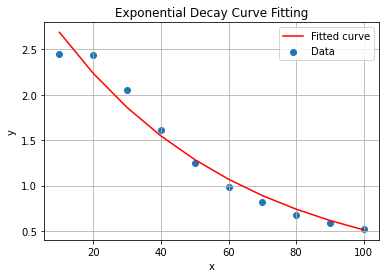

Fitted parameters (a, b): [3.23166764 0.01841036]


In [14]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit

# Given x and y values
x_values = np.array([10, 20, 30, 40, 50, 60, 70, 80, 90, 100])
y_values = np.array([2.44920454, 2.43683684, 2.0524846, 1.61170326, 1.25031626, 0.9833592, 0.82272979, 0.67723242, 0.58764707, 0.51940929])

# Define the function to fit (exponential decay)
def exponential_decay(x, a, b):
    return a * np.exp(-b * x)

# Fit the curve
popt, pcov = curve_fit(exponential_decay, x_values, y_values)

# Plot the data points
plt.scatter(x_values, y_values, label='Data')

# Plot the fitted curve
plt.plot(x_values, exponential_decay(x_values, *popt), 'r-', label='Fitted curve')

plt.xlabel('x')
plt.ylabel('y')
plt.legend()
plt.title('Exponential Decay Curve Fitting')
plt.grid(True)
plt.show()

# Print the parameters
print("Fitted parameters (a, b):", popt)


In [15]:
np.sqrt(avg_variance_frcc_SNR)

array([1.79091079, 2.12265361, 2.29923377, 2.27975969, 2.14669514,
       1.97722973, 1.84472701, 1.69623049, 1.59138255, 1.50595161])